In [2]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None
exp_path = Path.cwd().resolve() # experiment path
# visible GPUs
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import cv2 as cv
import numpy as np
import omidb
import matplotlib.pyplot as plt
import pandas as pd
from diffusers import DPMSolverMultistepScheduler, DiffusionPipeline
import torch
from PIL import Image

# Mask
Let's try to make the mask of the breast first.

In [16]:
def get_normal_BBox(image):
    """This function returns the mask of the breast, as well as the boudnig box that encopasses it.

    Args:
        image (np.array): image as array

    Returns:
        omidb.bbox, np.array: returns omidb.box and mask image as np.arrays
    """

    mask = cv.threshold(image, 0, 255, cv.THRESH_BINARY)[1]
    nb_components, output, stats, _ = cv.connectedComponentsWithStats(mask, connectivity=4)
    sizes = stats[:, -1]
    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]
    img2 = np.zeros(output.shape,dtype=np.uint8)
    img2[output == max_label] = 255
    contours, _ = cv.findContours(img2,cv.RETR_TREE,cv.CHAIN_APPROX_NONE)
    cnt = contours[0]
    aux_im = img2
    x,y,w,h = cv.boundingRect(cnt)
    cv.rectangle(aux_im,(x,y),(x+w,y+h),(255,0,0),5)
    out_bbox = omidb.mark.BoundingBox(x, y, x+w, y+h)
    
    return out_bbox, img2, mask # returns bounding box and mask image.

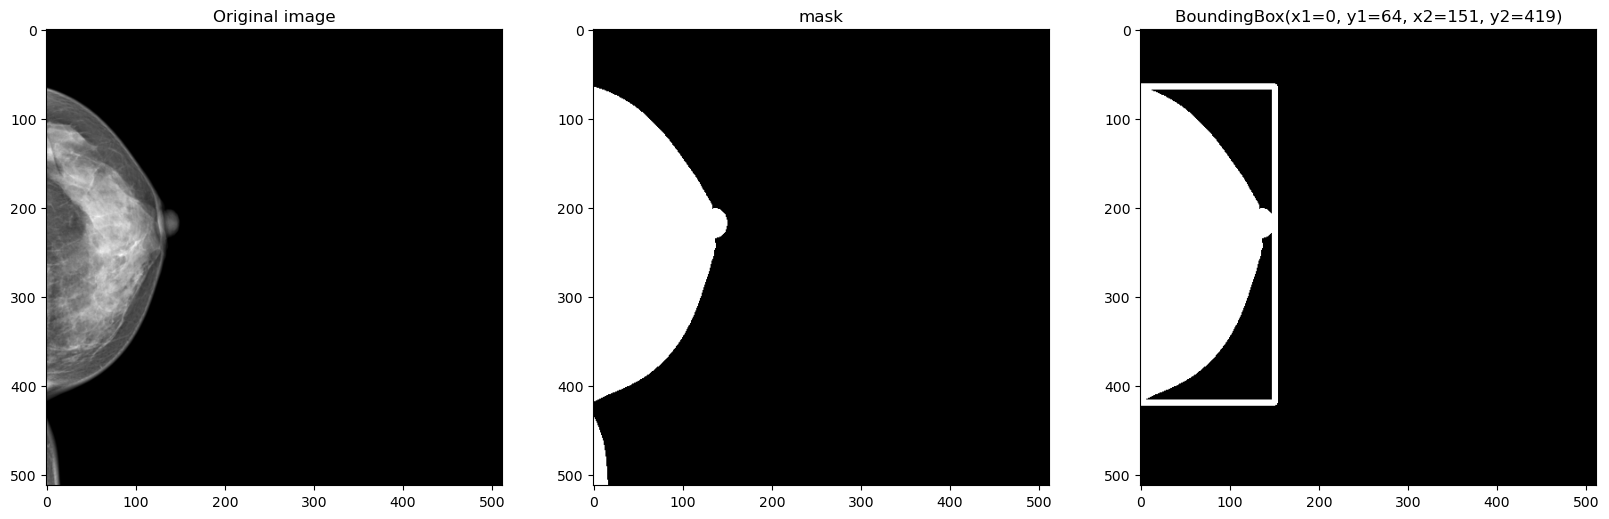

In [50]:
# we use the healthy images
images_directory = repo_path / 'data/vindr-mammo/images/siemens15k_RGB_healthy'
# get filenames of png files
filenames = [f for f in os.listdir(images_directory) if f.endswith('.png')]

# get the first image
filename = filenames[2]
# read image
image = cv.imread(str(images_directory / filename))[:,:,0] # one channel
# get bounding box
bbox, image_box, mask = get_normal_BBox(image)

# plot
fig, ax = plt.subplots(1,3,figsize=(20,10))
ax[0].imshow(image,'gray')
ax[0].set_title('Original image')
ax[1].imshow(mask,'gray')
ax[1].set_title('mask')
ax[2].imshow(image_box,'gray')
ax[2].set_title(f'{bbox}')
plt.show()


# BBoxes inside mask

Now, the idea is to create bboxes with lesions inside of the breast mask.<br>
For this we use the following idea:
- Get allowed coordinate values for the left upper corner of the bbox
- Sample from them randomly
- Get allowed bbox area and ratio values to compute the other three corners
- Check that all corners are inside the mask
- If not, redo steps above

## Allowed bbox size and ratio

Mean mask area: 3317.4748858447488 and std: 4865.377228290751


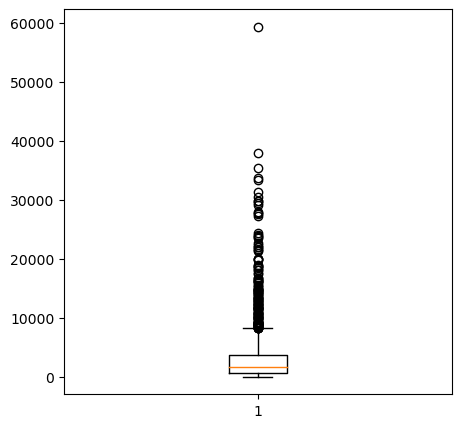

25th percentile: 720.0 and 75th percentile: 3721.0


In [103]:
# get directory with all masks
masks_directory = repo_path / 'data/vindr-mammo/masks/siemens15k_RGB_wlesions'
# get filenames of png files
filenames = [f for f in os.listdir(masks_directory) if f.endswith('.png')]
mask_areas = np.zeros(len(filenames))
for filename in filenames:    
    # read imae
    mask = cv.imread(str(masks_directory / filename)) [:,:,0] # one channel
    # compute mask area
    mask_areas[filenames.index(filename)] = np.sum(mask==255)

# the mean and std of the mask areas
print(f'Mean mask area: {np.mean(mask_areas)} and std: {np.std(mask_areas)}')
# box plot of mask areas
plt.figure(figsize=(5,5))
plt.boxplot(mask_areas)
plt.show()
# get 25th and 75th percentiles
q25, q75 = np.percentile(mask_areas, 25), np.percentile(mask_areas, 75)
print(f'25th percentile: {q25} and 75th percentile: {q75}')

In [105]:
# read annotation file
annotations = pd.read_csv(repo_path / 'data/vindr-mammo/metadata/finding_annotations.csv')
xmin = annotations['xmin']
ymin = annotations['ymin']
xmax = annotations['xmax']
ymax = annotations['ymax']
# get height and width of the bboxes
height = ymax - ymin
width = xmax - xmin
# remove NaNs
height = height[~np.isnan(height)]
width = width[~np.isnan(width)]
# compute ratios
ratios = height/width
# the mean and std of the ratios
mean_rt, stdrt = np.mean(ratios), np.std(ratios)
print(f'Mean ratio: {mean_rt} and std: {stdrt}')

Mean ratio: 1.1528661745531712 and std: 0.5001915347295389


# Generate bboxes

In [5]:
# get all healthy images filenames
images_directory = repo_path / 'data/vindr-mammo/images/siemens15k_RGB_healthy'
filenames = [f for f in os.listdir(images_directory) if f.endswith('.png')]

# Allowed bbox area and ratio
area_range = (int(q25), int(q75))
ratio_range = (mean_rt-stdrt, mean_rt+stdrt)

# example image
filename = filenames[0]
image = cv.imread(str(images_directory / filename))[:,:,0] # one channel
bbox, image_box, mask = get_normal_BBox(image) # get bounding box

NameError: name 'q25' is not defined

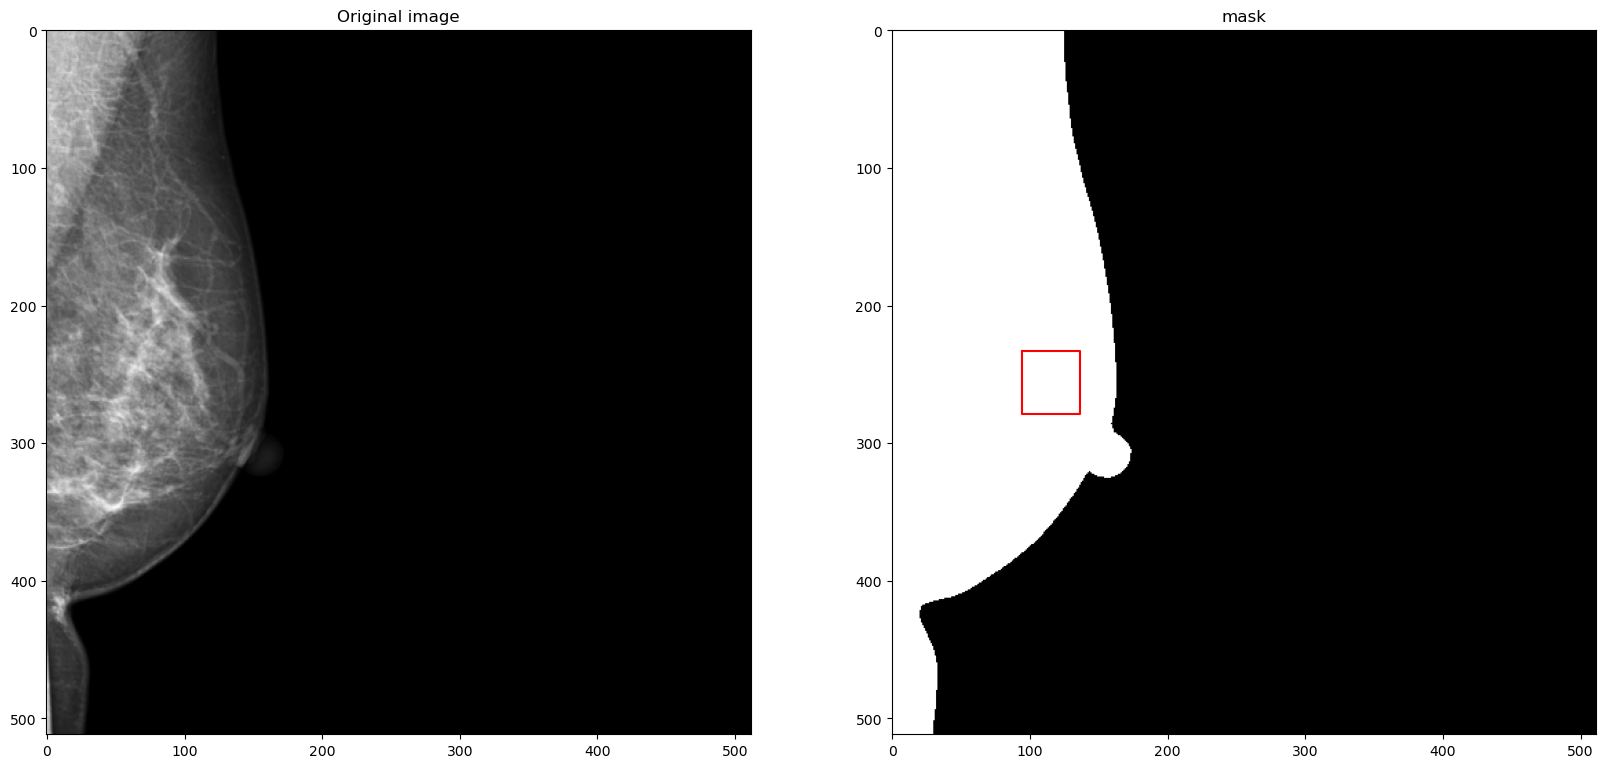

In [171]:
# define x and y range
xrange = (bbox.x1, bbox.x2)
yrange = (bbox.y1, bbox.y2)
# sample x and y
x1 = np.random.randint(xrange[0], xrange[1])
y1 = np.random.randint(yrange[0], yrange[1])
# sample area and ratio
area = np.random.randint(area_range[0], area_range[1])
ratio = np.random.uniform(ratio_range[0], ratio_range[1])

# compute width and height
width = int(np.sqrt(area*ratio))
height = int(np.sqrt(area/ratio))

# compute other corners
x2 = x1 + width
y2 = y1 + height

# check that all corners are inside the mask
# show new bbox overlapping mask
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(image,'gray')
ax[0].set_title('Original image')
ax[1].imshow(mask,'gray')
ax[1].set_title('mask')
ax[1].plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1],'r')
plt.show()

if np.sum(mask[y1:y2,x1:x2]==255) != width*height:
    print('Not all corners are inside the mask')

# Production trial

In [4]:
def get_normal_BBox(image):
    """This function returns the mask of the breast, as well as the boudnig box that encopasses it.

    Args:
        image (np.array): image as array

    Returns:
        omidb.bbox, np.array: returns omidb.box and mask image as np.arrays
    """

    mask = cv.threshold(image, 0, 255, cv.THRESH_BINARY)[1]
    nb_components, output, stats, _ = cv.connectedComponentsWithStats(mask, connectivity=4)
    sizes = stats[:, -1]
    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]
    img2 = np.zeros(output.shape,dtype=np.uint8)
    img2[output == max_label] = 255
    contours, _ = cv.findContours(img2,cv.RETR_TREE,cv.CHAIN_APPROX_NONE)
    cnt = contours[0]
    aux_im = img2
    x,y,w,h = cv.boundingRect(cnt)
    cv.rectangle(aux_im,(x,y),(x+w,y+h),(255,0,0),5)
    out_bbox = omidb.mark.BoundingBox(x, y, x+w, y+h)
    
    return out_bbox, img2, mask # returns bounding box and mask image.

def area_stats():
    """computes the 25th and 75th percentiles of the mask areas

    Returns:
        int: q25 and q75 integers
    """
    # get directory with all masks
    masks_directory = repo_path / 'data/vindr-mammo/masks/siemens15k_RGB_wlesions'
    # get filenames of png files
    filenames = [f for f in os.listdir(masks_directory) if f.endswith('.png')]
    mask_areas = np.zeros(len(filenames))
    for filename in filenames:    
        # read image
        mask = cv.imread(str(masks_directory / filename)) [:,:,0] # one channel
        # compute mask area
        mask_areas[filenames.index(filename)] = np.sum(mask==255)
    
    # get 25th and 75th percentiles
    q25, q75 = np.percentile(mask_areas, 25), np.percentile(mask_areas, 75)
    
    return int(q25), int(q75)

def bbox_ratios():
    """computes the mean and std of the ratios of the bboxes

    Returns:
        float: mean and std of the ratios as floats
    """
    # read annotation file
    annotations = pd.read_csv(repo_path / 'data/vindr-mammo/metadata/finding_annotations.csv')
    xmin = annotations['xmin']
    ymin = annotations['ymin']
    xmax = annotations['xmax']
    ymax = annotations['ymax']
    # get height and width of the bboxes
    height = ymax - ymin
    width = xmax - xmin
    # remove NaNs
    height = height[~np.isnan(height)]
    width = width[~np.isnan(width)]
    # compute ratios
    ratios = height/width
    # the mean and std of the ratios
    mean_rt, std_rt = np.mean(ratios), np.std(ratios)
    
    return mean_rt, std_rt

In [63]:
# prepare diffusion pipeline
model_dir='Likalto4/vindr_lesion-inpainting'
pipe = DiffusionPipeline.from_pretrained(
    model_dir,
    safety_checker=None,
    torch_dtype=torch.float32,
).to("cuda")
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()


# prepare healthy images filenames
images_directory = repo_path / 'data/vindr-mammo/images/siemens15k_RGB_healthy'
filenames = [f for f in os.listdir(images_directory) if f.endswith('.png')]

# prepare area and ratio ranges
q25, q75 = area_stats()
mean_rt, std_rt = bbox_ratios()
area_range = (q25, q75)
ratio_range = (mean_rt-std_rt, mean_rt+std_rt)

unet/diffusion_pytorch_model.safetensors not found
/home/ricardo/miniconda3/envs/dreambooth/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pu

In [77]:
# create dataframe for metadata
metadata = pd.DataFrame(columns=['filename','breast_bbox', 'lesion_bbox'])
## FOR # example image
for filename in filenames[0:10]:
    image = cv.imread(str(images_directory / filename))[:,:,0] # one channel
    bbox, image_box, mask = get_normal_BBox(image) # get bounding box
    # define x and y range
    xrange = (bbox.x1, bbox.x2)
    yrange = (bbox.y1, bbox.y2)

    while True: # Look for a valid bbox
        # sample x and y
        x1 = np.random.randint(xrange[0], xrange[1])
        y1 = np.random.randint(yrange[0], yrange[1])
        # sample area and ratio
        area = np.random.randint(area_range[0], area_range[1])
        ratio = np.random.uniform(ratio_range[0], ratio_range[1])

        # compute width and height
        width = int(np.sqrt(area*ratio))
        height = int(np.sqrt(area/ratio))

        # compute other corners
        x2 = x1 + width
        y2 = y1 + height

        if np.sum(mask[y1:y2,x1:x2]==255) == width*height: # if all corners are inside the mask
            # create mask of the bbox
            bbox_mask = np.zeros(image.shape,dtype=np.uint8)
            bbox_mask[y1:y2,x1:x2] = 255
            # save as pil
            bbox_mask = Image.fromarray(bbox_mask)
            break

    # # check that all corners are inside the mask
    # # show new bbox overlapping mask
    # fig, ax = plt.subplots(1,2,figsize=(20,10))
    # ax[0].imshow(image,'gray')
    # ax[0].set_title('Original image')
    # ax[1].imshow(mask,'gray')
    # ax[1].set_title('mask')
    # # use bbox_mask to show the bbox
    # ax[1].imshow(bbox_mask,'gray',alpha=0.5)
    # plt.show()

    # Se diffusion pipeline
    image_RGB = Image.open(images_directory / filename)
    prompt = "a mammogram with a lesion"
    negative_prompt = ""
    num_samples = 1
    # seed
    generator = torch.Generator(device='cuda')
    generator.manual_seed(1337)

    # HP
    diffusion_steps = 40
    guidance_scale = 4

    with torch.autocast("cuda"), torch.inference_mode():
        synth = pipe(
            prompt=prompt,
            image=image_RGB,
            mask_image=bbox_mask, # mask coming from the sketchpad
            negative_prompt=negative_prompt,
            num_images_per_prompt=num_samples,
            num_inference_steps=diffusion_steps,
            guidance_scale=guidance_scale,
            height=512,
            width=512,
            generator=None,
        ).images[0]

    # send to grayscale
    synth = np.array(synth)
    synth = cv.cvtColor(synth, cv.COLOR_RGB2GRAY)

    # # plot
    # fig, ax = plt.subplots(1,3,figsize=(20,10))
    # ax[0].imshow(image_RGB,'gray')
    # ax[0].set_title('Original image')
    # ax[1].imshow(synth,'gray')
    # ax[1].set_title('Inpainted image')
    # # difference
    # diff = abs(image-synth)
    # ax[2].imshow(diff,'gray')
    # ax[2].set_title('Difference')
    # plt.show()
    
    # Save important information
    cv.imwrite(f'data/sample/{filename}',synth)
    # save metadata using concat
    metadata = pd.concat(
        [metadata,
         pd.DataFrame([[filename, bbox, omidb.mark.BoundingBox(x1, y1, x2, y2)]],
            columns=['filename','breast_bbox', 'lesion_bbox'])
        ],
        ignore_index=True
    )
    # save csv
metadata.to_csv('data/sample/metadata.csv',index=False)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]